In [1]:
# install.packages("GGally")   # Uncomment this line if GGally is not installed
library(tidyverse)
library(caret)
library(ggplot2)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘GGally’


The following object is masked from ‘package:dplyr’:

    nasa




# Predicting Tennis Match Winners

# Introduction

The US Open grand slam tennis tournament has an estimated total prize money pool of USD $50.4 million. This puts it in line with high-value tournaments such as the MLB World Series and the PGA FedEx Cup (source: pledgesports.org). With such a high potential payoff, there is much incentive for competitive tennis athletes and coaches to understand the player attributes that contribute to tournament success. 

This project will study the data of tennis match results collected for the top 500 tennis players from 2017-2019. The purpose of the study is to determine whether certain attributes contribute to greater competitive success by analyzing player and match information. The dataset contains results from nearly 7,000 matches and includes the winner and loser heights, playing hands, countries of origin, ages, match times and other information (source: https://github.com/JeffSackmann/tennis_atp). 

# Preliminary Exploratory Data Analysis

The tennis player data available on Jeff Sackmann's GitHub (here: https://github.com/JeffSackmann/tennis_atp) is split into CSV files per year. To begin, we will use the `read_csv()` function to scrape the data from the web and use `rbind()` to combine the three dataframes into a single one. 

In [2]:
data2017 <- read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2017.csv', col_types = cols())
data2018 <- read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2018.csv', col_types = cols())
data2019 <- read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2019.csv', col_types = cols())

combined_data <- rbind(data2017, data2018, data2019)



Next, we select the columns that we are interested in and tidy the data based on whether the given match `result` was a win or loss. 

In [3]:
tennis <- combined_data %>% 
    select(winner_hand, loser_hand, winner_age, loser_age, winner_ht, loser_ht, minutes, w_ace, l_ace)

tennis_win = select(tennis, winner_hand, winner_age, winner_ht, minutes, w_ace)
tennis_loss = select(tennis, loser_hand, loser_age, loser_ht, minutes, l_ace)

tennis_win = mutate(tennis_win, hand = winner_hand, age = winner_age, height = winner_ht, aces = w_ace, result = 'w') %>%
            select(-winner_hand, -winner_age, -winner_ht, -w_ace)
tennis_loss = mutate(tennis_loss, hand = loser_hand, age = loser_age, height = loser_ht, aces = l_ace, result = 'l') %>%
            select(-loser_hand, -loser_age, -loser_ht, -l_ace)

cleaned_data = rbind(tennis_win, tennis_loss)



The match `result` is then converted to a factor. This allows us to categorize each match winner and loser. The results of this categorization is shown below.

In [4]:
cleaned_data = mutate(cleaned_data, result = as.factor(result))
rows = sample(nrow(cleaned_data))
cleaned_data = cleaned_data[rows, ]

head(cleaned_data)

minutes,hand,age,height,aces,result
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
125,R,34.87748,190,5,l
148,U,20.94182,NA,12,w
129,L,20.53662,NA,5,w
73,R,21.13347,NA,8,w
154,R,27.22519,188,14,w
132,R,20.16427,198,19,w




Next, we separate the tidied data into a `training_set` and a `testing_set`. The `training_set` will be given 0.75 of the `cleaned_data` set; `testing_set` will be given 0.25. This is so that our model is trained against the training set and we can later perform cross-validation with a testing set to find an optimal k-value.

We will use the `createDataPartition()` function and the `slice()` function to split the data into two sets.

In [5]:
set.seed(42)

training_rows <- cleaned_data %>%
    select(result) %>% 
    unlist() %>%
    createDataPartition (p = 0.75 , list = FALSE)

training_set <- cleaned_data %>% slice (training_rows)
testing_set <- cleaned_data %>% slice (-training_rows)



Now that the sets have been partitioned, we plot a matrix of the parameters that which we will later use to perform analysis of predicted player match outcomes. 

There are two goals we want to achieve with our visualization:
- The correlation between our predicting variables. If one variable is highly correlated to another, we may eliminate them and simplify the modelling process.
- The correlation between our predicting variables with our labeling variables.

We achieve this by using the `ggpair()` and `ggcorr()` functions. While `ggpair()` gives us a comprehensive view of how each variable correlates to each other through histograms, box plots, regression model and more, `ggcorr()` provides a more straightforward matrix with results of correlation between variables.

Warning message:
“Ignoring unknown parameters: title”
Warning message:
“Removed 309 rows containing non-finite values (stat_density).”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 312 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 4798 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 313 rows containing missing values”
Warning message:
“Removed 309 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 312 rows containing missing values (geom_point).”
Warning message:
“Removed 5 rows containing non-finite values (stat_density).”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 4661 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 245

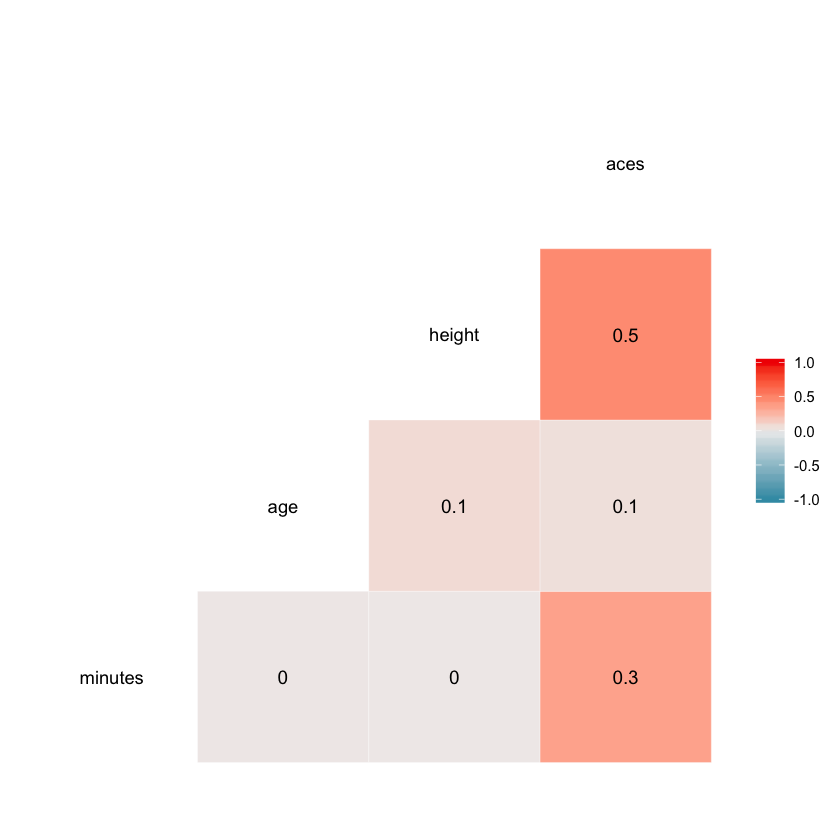

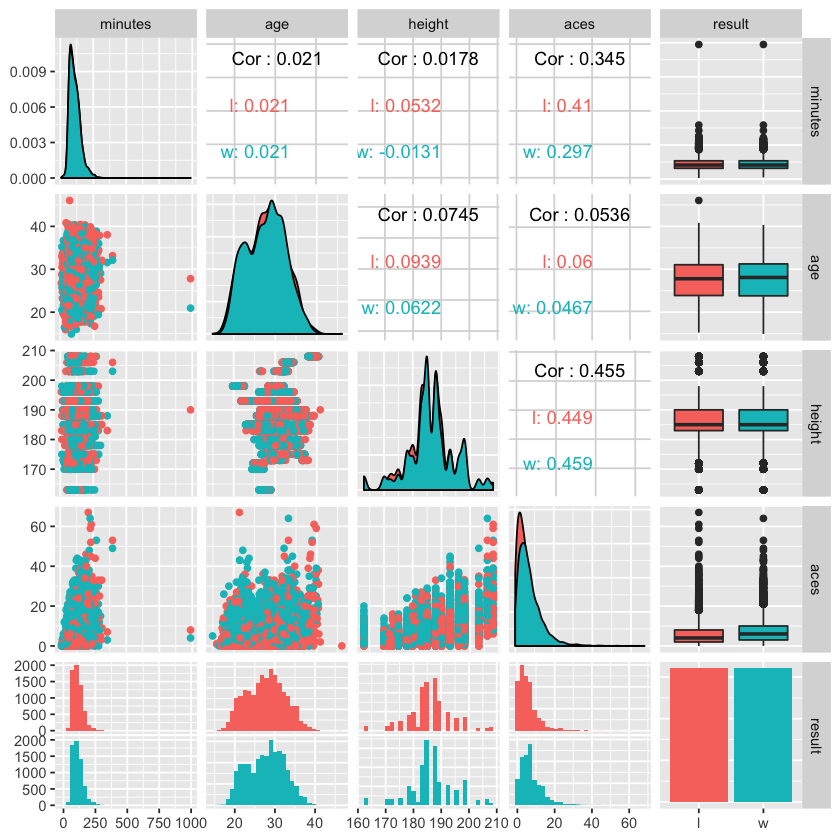

In [6]:
options (repr.plot.width=7, repr.plot.height=7)
tennis_matrix_train <- ggcorr(select(training_set, -hand, -result), label = TRUE, title = "Training Data Correlations", )
tennis_matrix_train

training_set2 = select(training_set, -hand)
tennis_train_pairs = ggpairs(training_set2, columns = 1:5, ggplot2::aes(colour=result), progress = FALSE)
tennis_train_pairs

In [7]:
training_table = group_by(training_set, hand) %>%
    summarize(count = n())
training_table

hand,count
<chr>,<int>
L,1849
R,10649
U,319
NA,17


# Methods

As seen in the **Preliminary Exploratory Data Analysis** section above, the data was wrangled using the read_csv() function on the 2017, 2018, and 2019 ATP Matches data from Jeff Slackmann's tennis_atp repository (at: https://github.com/JeffSackmann/tennis_atp). In order to combine the three data frames into one, we used the rbind() function. Cleaning the data involved separating the winners and losers, creating a new result column, and then recombining them into one cleaned data set.

The following columns below will be used for classification:

* item winner_hand (the dominant hand of the winner)
* item loser_hand (the dominant hand of the loser)
* item winner_age 
* item loser_age
* item winner_ht (the height of the winner)
* item loser_ht (the height of the loser)
* item minutes (The length of the match)
* item w_ace (number of aces the winner had)
* item l_ace (the number aces the loser had)

These columns will also be used to create a knn-model. This is done in order to predict whether a hypothetical player with given attributes will win or lose a future given match. We will be removing the leftover columns from the set as they are not variables of interest for this analysis.

To visualize the classification results, we will plot the results of the predicted outcomes of the testing set against the actual results.

# Expected outcomes and significance

We expect to find that certain attributes will be more positively correlated with successful match outcomes. For example, an increase in player height may correlate with the number of aces a player gets in a match, which may in turn result in greater player success. 

In general we expect to find that some attributes contribute to success and others may do the opposite. These findings could help in the scouting of new tennis player talent for sponsorships by corporations that sell tennis gear. 

For example, if a new player enters the scene with a plethora of attributes that contribute positively to a players success, a corporation may wish to engage in early sponsorship, sponsoring them at a lower rate and receiving greater value out of their sponsorship spending rather than spending sponsorship dollars on proven successful players that request higher fees. 

Future questions that this analysis could lead to is an examination as to why certian attributes contribute to success. For example if there is an ideal range of height for a pro player, why are the heights within that range ideal? 